In [143]:
import numpy as np
import pandas as pd
import random
import chars2vec
import faiss
from sklearn.metrics.pairwise import cosine_similarity
import Levenshtein as lev

# Part-1

In [55]:
df=pd.read_csv('Generated_Data.csv')

In [56]:
df.head()

,name,phone,address,postalZip,region,appointmentdate
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
1,Vance Pawan,(916) 648-8254,"Ap #460-3504 Lorem, Ave",24169,Montana,03-07-2024
2,Lila Chande,(725) 517-5611,Ap #592-816 Vitae Rd.,85787,Virginia,08-10-2023
3,Signe Shaw,1-361-885-3442,"Ap #247-1256 Sed, Rd.",63438,Florida,03-25-2023
4,Lucian Lambert,1-596-511-3644,401-1079 Senectus Ave,48394,Georgia,12-08-2023


In [57]:
p_df = df[['phone']].copy()

In [59]:
# p_df= p_df['phone']

In [58]:
p_df.head(10)

,phone
0,(833) 925-5254
1,(916) 648-8254
2,(725) 517-5611
3,1-361-885-3442
4,1-596-511-3644
5,(654) 378-2493
6,(437) 364-7033
7,1-429-456-4436
8,(392) 150-8756
9,1-618-565-9763


In [60]:
print(p_df)

             phone
0   (833) 925-5254
1   (916) 648-8254
2   (725) 517-5611
3   1-361-885-3442
4   1-596-511-3644
..             ...
95  (405) 279-9472
96  (357) 346-3055
97  1-887-648-9784
98  1-295-475-7687
99  1-885-963-5745

[100 rows x 1 columns]


In [61]:
print(p_df.columns)

Index(['phone'], dtype='object')


In [20]:
# p_df.columns = ['phone_number']

In [74]:
p_df['phone_clean'] = p_df['phone'].str.replace(r'[()\-\s]', '', regex=True)  # Remove () - and spaces

In [79]:
p_df['phone_clean'] = p_df['phone_clean'].str.replace(r'^1', '', regex=True) # Remove leading 1

In [80]:
p_df

,phone,phone_clean
0,(833) 925-5254,8339255254
1,(916) 648-8254,9166488254
2,(725) 517-5611,7255175611
3,1-361-885-3442,3618853442
4,1-596-511-3644,5965113644
...,...,...
95,(405) 279-9472,4052799472
96,(357) 346-3055,3573463055
97,1-887-648-9784,8876489784
98,1-295-475-7687,2954757687


## ERROR CREATION

### Change one digit

In [83]:
def introduce_error(phone_number):
    if len(phone_number) == 0:
        return phone_number
    
    phone_list = list(phone_number)
    index = random.randint(0, len(phone_list) - 1)  # Choose a random index to introduce an error
    
    original_digit = phone_list[index]
    new_digit = random.choice([d for d in '0123456789' if d != original_digit])  # Choose a different digit
    
    phone_list[index] = new_digit  # Replace the original digit with the new one
    return ''.join(phone_list)

# Apply the error introduction
p_df['phone_error_digit'] = p_df['phone_clean'].apply(introduce_error)

# Display the DataFrame with the new 'phone_error_digit' column
print(p_df[['phone_clean', 'phone_error_digit']])

   phone_clean phone_error_digit
0   8339255254        8339255252
1   9166488254        9166488654
2   7255175611        7255775611
3   3618853442        3615853442
4   5965113644        5963113644
..         ...               ...
95  4052799472        4052999472
96  3573463055        3579463055
97  8876489784        8676489784
98  2954757687        1954757687
99  8859635745        5859635745

[100 rows x 2 columns]


In [85]:
p_df.head(10)

,phone,phone_clean,phone_error_digit
0,(833) 925-5254,8339255254,8339255252
1,(916) 648-8254,9166488254,9166488654
2,(725) 517-5611,7255175611,7255775611
3,1-361-885-3442,3618853442,3615853442
4,1-596-511-3644,5965113644,5963113644
5,(654) 378-2493,6543782493,6043782493
6,(437) 364-7033,4373647033,4373648033
7,1-429-456-4436,4294564436,4694564436
8,(392) 150-8756,3921508756,3921708756
9,1-618-565-9763,6185659763,6187659763


### Add 1 to first number

In [86]:
def introduce_error_one(phone_number):
    return '1' + phone_number  # Add '1' to the start of the phone number

# Apply the error introduction
p_df['phone_error_one'] = p_df['phone_clean'].apply(introduce_error_one)

# Display the DataFrame with the new 'phone_error_digit' column
print(p_df[['phone_clean', 'phone_error_one']])

   phone_clean phone_error_one
0   8339255254     18339255254
1   9166488254     19166488254
2   7255175611     17255175611
3   3618853442     13618853442
4   5965113644     15965113644
..         ...             ...
95  4052799472     14052799472
96  3573463055     13573463055
97  8876489784     18876489784
98  2954757687     12954757687
99  8859635745     18859635745

[100 rows x 2 columns]


In [87]:
p_df

,phone,phone_clean,phone_error_digit,phone_error_one
0,(833) 925-5254,8339255254,8339255252,18339255254
1,(916) 648-8254,9166488254,9166488654,19166488254
2,(725) 517-5611,7255175611,7255775611,17255175611
3,1-361-885-3442,3618853442,3615853442,13618853442
4,1-596-511-3644,5965113644,5963113644,15965113644
...,...,...,...,...
95,(405) 279-9472,4052799472,4052999472,14052799472
96,(357) 346-3055,3573463055,3579463055,13573463055
97,1-887-648-9784,8876489784,8676489784,18876489784
98,1-295-475-7687,2954757687,1954757687,12954757687


## Char2Vec model

In [89]:
# Models names: 'eng_50', 'eng_100', 'eng_150', 'eng_200', 'eng_300'
char2vec_model = chars2vec.load_model('eng_50')

In [97]:
def get_vector(text,model):
    words = text.split()
    word_embeddings = model.vectorize_words(words)
    if len(word_embeddings) > 0:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size) 

#### Sample Test

In [90]:
test=p_df['phone_clean'][0]

In [91]:
print(test)

8339255254


In [98]:
vec=get_vector(test,char2vec_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


In [99]:
print(vec)

[ 0.18541794 -0.352451   -0.6065817  -0.0308524  -0.09231423  0.07682339
 -0.16242413  0.42011356  0.5217423   0.24282144  0.4812268   0.20814289
  0.4875292  -0.00671829 -0.33885285  0.04173213  0.2543973  -0.28556597
 -0.12183262 -0.5353205   0.05600805  0.10065119  0.02393317  0.19210257
 -0.79476756  0.18932293 -0.27474585  0.24664143  0.20442827 -0.1620124
  0.45323554 -0.18927787  0.60195494 -0.65342975  0.21893974  0.5120181
 -0.46001977  0.29558536  0.6272836   0.27943727 -0.8323958   0.37908107
 -0.09180573 -0.55912405  0.1338896   0.22097328 -0.6829923   0.2637634
  0.50870156  0.14281073]


### Char2vec Vector Generation

In [101]:
# Apply vectorization
for column in ['phone', 'phone_clean', 'phone_error_digit', 'phone_error_one']:
    p_df[f'{column}_vector'] = p_df[column].apply(lambda x: get_vector(x, char2vec_model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━

In [102]:
p_df.head(20)

,phone,phone_clean,phone_error_digit,phone_error_one,phone_vector,phone_clean_vector,phone_error_digit_vector,phone_error_one_vector
0,(833) 925-5254,8339255254,8339255252,18339255254,"[-0.086652465, -0.20205903, -0.35300657, -0.09...","[0.18541794, -0.352451, -0.6065817, -0.0308524...","[0.18223518, -0.35247606, -0.62185985, -0.0285...","[0.14435486, -0.28423727, -0.5622817, 0.205165..."
1,(916) 648-8254,9166488254,9166488654,19166488254,"[-0.012659147, -0.14969863, -0.16550575, 0.009...","[0.070784226, -0.425155, 0.14527024, -0.067075...","[0.15958385, -0.34774968, 0.20743887, -0.10356...","[0.087185755, -0.3610482, 0.190752, 0.17259067..."
2,(725) 517-5611,7255175611,7255775611,17255175611,"[0.008137657, -0.1466138, -0.3053554, 0.153248...","[0.13273644, -0.41022336, -0.41375956, 0.14595...","[0.18982628, -0.38985384, -0.33810484, 0.10773...","[0.17421655, -0.33509126, -0.33288556, 0.32784..."
3,1-361-885-3442,3618853442,3615853442,13618853442,"[0.15166193, -0.2979848, 0.30028865, 0.3499793...","[0.17109743, 0.017066706, 0.12089443, 0.194100...","[0.20336644, -0.000639222, -0.046880413, 0.142...","[0.1617387, 0.07593638, 0.13833563, 0.35855705..."
4,1-596-511-3644,5965113644,5963113644,15965113644,"[-0.22412713, -0.6125737, -0.2782295, 0.114660...","[0.031393066, -0.384621, -0.32590356, -0.04322...","[0.11131897, -0.3026136, -0.19667198, 0.004357...","[0.0563423, -0.31947282, -0.20236333, 0.215307..."
5,(654) 378-2493,6543782493,6043782493,16543782493,"[0.025409637, -0.17862841, -0.21218348, -0.033...","[0.29357722, -0.30037647, -0.27098, 0.01820229...","[0.33540112, -0.2584688, -0.28417116, -0.04919...","[0.3101171, -0.252547, -0.16099283, 0.12528059..."
6,(437) 364-7033,4373647033,4373648033,14373647033,"[0.20431508, -0.033692807, -0.16455312, -0.084...","[0.49403617, -0.11664331, -0.18957603, -0.0481...","[0.45537633, -0.13672817, -0.10251773, -0.0516...","[0.48426408, -0.08303435, -0.13955793, 0.05458..."
7,1-429-456-4436,4294564436,4694564436,14294564436,"[0.25048375, -0.6221113, -0.35516196, -0.00547...","[0.4313181, -0.42928785, -0.33214918, -0.20287...","[0.4857939, -0.33104047, -0.3833652, -0.312253...","[0.45116794, -0.41365093, -0.31279355, -0.0514..."
8,(392) 150-8756,3921508756,3921708756,13921508756,"[0.038939893, 0.020256143, -0.2703256, 0.13728...","[0.17411546, -0.24724747, -0.34830803, 0.02799...","[0.26788965, -0.2508274, -0.19740354, 0.068995...","[0.19031131, -0.17868422, -0.34341404, 0.26957..."
9,1-618-565-9763,6185659763,6187659763,16185659763,"[0.16966575, -0.47754464, -0.4385661, 0.392428...","[0.2730231, -0.065882996, -0.3359393, 0.234414...","[0.3335089, -0.20379514, -0.13578604, 0.211915...","[0.2774709, 0.034707252, -0.19898145, 0.434819..."


#### Cosine similarity

In [104]:
# Convert vector columns to arrays
phone_clean_vectors = np.array(p_df['phone_clean_vector'].tolist())
phone_error_digit_vectors = np.array(p_df['phone_error_digit_vector'].tolist())
phone_error_one_vectors = np.array(p_df['phone_error_one_vector'].tolist())

In [106]:
# Define the function to calculate average cosine similarity
def average_cosine_similarity(similarity_matrix):
    """Compute the average cosine similarity from a similarity matrix."""
    return np.mean(similarity_matrix)

# Assuming `similarity_clean_digit` and `similarity_clean_one` are your matrices
avg_similarity_clean_digit = average_cosine_similarity(similarity_clean_digit)
avg_similarity_clean_one = average_cosine_similarity(similarity_clean_one)

# Print average similarities
print("Average Cosine Similarity between phone_clean and phone_error_digit:")
print(avg_similarity_clean_digit)
print()

print("Average Cosine Similarity between phone_clean and phone_error_one:")
print(avg_similarity_clean_one)

Average Cosine Similarity between phone_clean and phone_error_digit:
0.7085007

Average Cosine Similarity between phone_clean and phone_error_one:
0.7032016


In [120]:
def compute_and_print_similarity(row, char2vec_model):
    """Compute cosine similarities for a single row and print the results."""
    phone_clean_vector = np.array(get_vector(row['phone_clean'], char2vec_model))
    phone_error_digit_vector = np.array(get_vector(row['phone_error_digit'], char2vec_model))
    phone_error_one_vector = np.array(get_vector(row['phone_error_one'], char2vec_model))
    
    # Compute cosine similarities
    similarity_clean_digit = cosine_similarity([phone_clean_vector], [phone_error_digit_vector])[0][0]
    similarity_clean_one = cosine_similarity([phone_clean_vector], [phone_error_one_vector])[0][0]
    
    # Print results
    print(f"Phone: {row['phone_clean']}")
    print(f"Cosine Similarity with phone_error_digit: {similarity_clean_digit:.4f}")
    print(f"Cosine Similarity with phone_error_one: {similarity_clean_one:.4f}")
    print()

In [121]:
# Iterate through each row and compute similarities
for _, row in p_df.iterrows():
    compute_and_print_similarity(row,char2vec_model )

Phone: 8339255254
Cosine Similarity with phone_error_digit: 0.9789
Cosine Similarity with phone_error_one: 0.9744

Phone: 9166488254
Cosine Similarity with phone_error_digit: 0.9711
Cosine Similarity with phone_error_one: 0.9482

Phone: 7255175611
Cosine Similarity with phone_error_digit: 0.9639
Cosine Similarity with phone_error_one: 0.9835

Phone: 3618853442
Cosine Similarity with phone_error_digit: 0.9779
Cosine Similarity with phone_error_one: 0.9566

Phone: 5965113644
Cosine Similarity with phone_error_digit: 0.9486
Cosine Similarity with phone_error_one: 0.9483

Phone: 6543782493
Cosine Similarity with phone_error_digit: 0.9578
Cosine Similarity with phone_error_one: 0.9647

Phone: 4373647033
Cosine Similarity with phone_error_digit: 0.9691
Cosine Similarity with phone_error_one: 0.9821

Phone: 4294564436
Cosine Similarity with phone_error_digit: 0.9513
Cosine Similarity with phone_error_one: 0.9833

Phone: 3921508756
Cosine Similarity with phone_error_digit: 0.9724
Cosine Simila

#### Levenshtein Distance

In [116]:
# Define a function to compute Levenshtein distance and similarity
def compute_and_print_levenshtein(row):
    """Compute Levenshtein distances for a single row and print the results."""
    phone_clean = row['phone_clean']
    phone_error_digit = row['phone_error_digit']
    phone_error_one = row['phone_error_one']
    
    # Compute Levenshtein distances
    distance_digit = lev.distance(phone_clean, phone_error_digit)
    distance_one = lev.distance(phone_clean, phone_error_one)
    
    # Print results
    print(f"Phone: {phone_clean}")
    print(f"Levenshtein Distance with phone_error_digit: {distance_digit}")
    print(f"Levenshtein Distance with phone_error_one: {distance_one}")
    print()


In [117]:
for _, row in p_df.iterrows():
    compute_and_print_levenshtein(row)

Phone: 8339255254
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

Phone: 9166488254
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

Phone: 7255175611
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

Phone: 3618853442
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

Phone: 5965113644
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

Phone: 6543782493
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

Phone: 4373647033
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

Phone: 4294564436
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

Phone: 3921508756
Levenshtein Distance with phone_error_digit: 1
Levenshtein Distance with phone_error_one: 1

P

# Part-2

In [130]:
df=pd.read_csv('phone_numbers.csv')

In [131]:
df.head()

,ID,Phone Number
0,1,9128909138
1,2,9224616488
2,3,9014331082
3,4,5427258865
4,5,3116178530


In [132]:
p_df = df[['Phone Number']].copy()

In [133]:
p_df

,Phone Number
0,9128909138
1,9224616488
2,9014331082
3,5427258865
4,3116178530
...,...
95,12086615014
96,18137326087
97,12946035640
98,5099321051


In [139]:
type(p_df)

pandas.core.frame.DataFrame

In [134]:
# The number are cleaned, No need of data cleaning.

In [140]:
# Ensure the 'Phone Number' column is of type string
p_df['Phone Number'] = p_df['Phone Number'].astype(str)

# Remove leading '1' if present
p_df['Phone Number'] = p_df['Phone Number'].str.replace(r'^1', '', regex=True)

In [142]:
p_df

,Phone Number
0,9128909138
1,9224616488
2,9014331082
3,5427258865
4,3116178530
...,...
95,2086615014
96,8137326087
97,2946035640
98,5099321051


## Vectors using Faiss

In [144]:
phone_numbers=p_df

In [147]:
# Function to clean phone numbers (remove non-digit characters)
def clean_phone_number(phone_number):
    return ''.join(filter(str.isdigit, phone_number))

# Function to convert phone number to vector
def phone_to_vector(phone_number):
    cleaned_phone = clean_phone_number(phone_number)
    return np.array([int(digit) for digit in cleaned_phone], dtype=np.float32)

# Clean and convert phone numbers to vectors
phone_numbers = p_df['Phone Number'].tolist()
phone_vectors = np.array([phone_to_vector(phone) for phone in phone_numbers])

# Create FAISS index
dimension = phone_vectors.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance (Euclidean)
index.add(phone_vectors)

# Search for similar phone numbers
def search_similar_phone_numbers(query_phone, k=3):
    query_vector = phone_to_vector(query_phone).reshape(1, -1)
    distances, indices = index.search(query_vector, k)
    return [(phone_numbers[i], distances[0][j]) for j, i in enumerate(indices[0])]

# # Example usage
# query_phone = '(950) 425-4485 x053'
# similar_phones = search_similar_phone_numbers(query_phone, k=3)
# print(similar_phones)

In [196]:
# # Find closest phone numbers for all phone numbers in the dataset using FAISS
# closest_numbers_faiss = {}
# for phone in phone_numbers:
#     similar_phones = search_similar_phone_numbers(phone, k=3, threshold=236.0)
#     closest_numbers_faiss[phone] = similar_phones

In [148]:
# # Function to convert phone number to vector
# def phone_to_vector(phone_number):
#     return np.array([int(digit) for digit in phone_number], dtype=np.float32)

# # # Example phone numbers
# # phone_numbers = [
# #     "1234567890",
# #     "1234567891",
# #     "1234567889",
# #     "9876543210",
# #     "9876543209"
# # ]

# # phone_numbers = pd.dataframe(p_df)

# # Convert phone numbers to vectors
# phone_vectors = np.array([phone_to_vector(phone) for phone in phone_numbers])

# # Create FAISS index
# dimension = phone_vectors.shape[1]
# index = faiss.IndexFlatL2(dimension)  # L2 distance (Euclidean)
# index.add(phone_vectors)

# # Search for similar phone numbers
# def search_similar_phone_numbers(query_phone, k=3):
#     query_vector = phone_to_vector(query_phone).reshape(1, -1)
#     distances, indices = index.search(query_vector, k)
#     return [(phone_numbers[i], distances[0][j]) for j, i in enumerate(indices[0])]


In [154]:
phone_numbers

['9128909138',
 '9224616488',
 '9014331082',
 '5427258865',
 '3116178530',
 '9656176957',
 '5572554555',
 '9324686312',
 '9588933576',
 '5906771747',
 '8188394257',
 '6807298704',
 '8645967264',
 '8412844515',
 '6829914493',
 '7163455833',
 '7799103697',
 '4615076039',
 '5055361531',
 '8799405452',
 '2847196235',
 '8709643172',
 '4047544184',
 '8523892704',
 '2232977248',
 '9265885756',
 '2883294937',
 '3816765103',
 '4847895942',
 '9482306322',
 '6797417405',
 '2646199405',
 '6888764264',
 '7146931155',
 '9878971937',
 '8193987581',
 '8296797102',
 '7718187610',
 '6134394373',
 '5444342059',
 '7762780137',
 '3922776680',
 '2632977439',
 '6175823396',
 '4868464968',
 '6083848714',
 '3087852851',
 '5787301552',
 '2607552953',
 '4622393667',
 '4386107190',
 '3283595505',
 '4107205992',
 '2943150492',
 '9278862650',
 '5422850502',
 '6476914067',
 '8068909153',
 '3647970897',
 '7846336488',
 '8009871828',
 '9544577213',
 '9997579538',
 '5206428107',
 '6145528291',
 '8372002760',
 '92520721

In [155]:
phone_vectors

array([[9., 1., 2., 8., 9., 0., 9., 1., 3., 8.],
       [9., 2., 2., 4., 6., 1., 6., 4., 8., 8.],
       [9., 0., 1., 4., 3., 3., 1., 0., 8., 2.],
       [5., 4., 2., 7., 2., 5., 8., 8., 6., 5.],
       [3., 1., 1., 6., 1., 7., 8., 5., 3., 0.],
       [9., 6., 5., 6., 1., 7., 6., 9., 5., 7.],
       [5., 5., 7., 2., 5., 5., 4., 5., 5., 5.],
       [9., 3., 2., 4., 6., 8., 6., 3., 1., 2.],
       [9., 5., 8., 8., 9., 3., 3., 5., 7., 6.],
       [5., 9., 0., 6., 7., 7., 1., 7., 4., 7.],
       [8., 1., 8., 8., 3., 9., 4., 2., 5., 7.],
       [6., 8., 0., 7., 2., 9., 8., 7., 0., 4.],
       [8., 6., 4., 5., 9., 6., 7., 2., 6., 4.],
       [8., 4., 1., 2., 8., 4., 4., 5., 1., 5.],
       [6., 8., 2., 9., 9., 1., 4., 4., 9., 3.],
       [7., 1., 6., 3., 4., 5., 5., 8., 3., 3.],
       [7., 7., 9., 9., 1., 0., 3., 6., 9., 7.],
       [4., 6., 1., 5., 0., 7., 6., 0., 3., 9.],
       [5., 0., 5., 5., 3., 6., 1., 5., 3., 1.],
       [8., 7., 9., 9., 4., 0., 5., 4., 5., 2.],
       [2., 8., 4., 

#### Sample test faiss

In [156]:

# Test search
query_phone = "2604181717"  # A phone number with a typo
similar_phones = search_similar_phone_numbers(query_phone, k=3)

print("Query Phone Number:", query_phone)
print("Similar Phone Numbers:")
for phone, distance in similar_phones:
    print(f"Phone: {phone}, Distance: {distance}")



Query Phone Number: 2604181717
Similar Phone Numbers:
Phone: 4622393667, Distance: 47.0
Phone: 5906771747, Distance: 68.0
Phone: 2607552953, Distance: 71.0


### After adding Thrushold

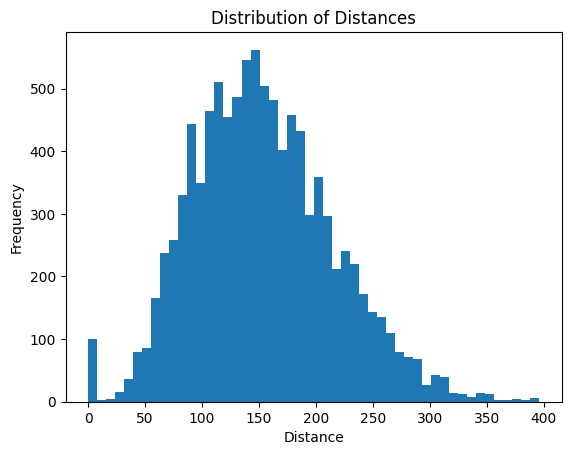

Suggested threshold: 100.80000000000018


In [172]:
 # Perform a search on all phone numbers against each other to collect distances
all_distances = []
for phone in phone_numbers:
    query_vector = phone_to_vector(phone).reshape(1, -1)
    distances, _ = index.search(query_vector, len(phone_numbers))
    all_distances.extend(distances[0])

# Convert to a NumPy array for easier analysis
all_distances = np.array(all_distances)

# Analyze the distribution of distances
import matplotlib.pyplot as plt

plt.hist(all_distances, bins=50)
plt.title('Distribution of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Set a threshold based on the analysis
threshold = np.percentile(all_distances, 20)
print(f'Suggested threshold: {threshold}')


In [176]:
# Search for similar phone numbers with a distance threshold
def search_similar_phone_numbers(query_phone, k=3, threshold=100.0):
    query_vector = phone_to_vector(query_phone).reshape(1, -1)
    distances, indices = index.search(query_vector, k)
    
    # Filter results based on the threshold
    filtered_results = [
        (phone_numbers[i], distances[0][j]) 
        for j, i in enumerate(indices[0]) 
        if distances[0][j] <= threshold
    ]
    
    return filtered_results

##### Sample Test

In [185]:
query_phone = '9163456833'
similar_phones = search_similar_phone_numbers(query_phone, k=3, threshold=40.0)
print(similar_phones)

[('7163455833', 5.0)]


#### Iterate through

In [199]:
# Find closest phone numbers for all phone numbers in the dataset
closest_numbers = {}
for phone in phone_numbers:
    similar_phones = search_similar_phone_numbers(phone, k=5, threshold=100.0)
    closest_numbers[phone] = similar_phones

# Print the results
for phone, similars in closest_numbers.items():
    print(f'Phone number: {phone}')
    for similar in similars:
        print(f'\tSimilar phone: {similar[0]}, Distance: {similar[1]}')

Phone number: 9128909138
	Similar phone: 9128909138, Distance: 0.0
	Similar phone: 8068909153, Distance: 47.0
	Similar phone: 5206428107, Distance: 65.0
	Similar phone: 9224616488, Distance: 70.0
	Similar phone: 8137326087, Distance: 79.0
Phone number: 9224616488
	Similar phone: 9224616488, Distance: 0.0
	Similar phone: 8137326087, Distance: 39.0
	Similar phone: 6175823396, Distance: 56.0
	Similar phone: 7846336488, Distance: 61.0
	Similar phone: 9128909138, Distance: 70.0
Phone number: 9014331082
	Similar phone: 9014331082, Distance: 0.0
	Similar phone: 5515452152, Distance: 58.0
	Similar phone: 4047544184, Distance: 62.0
	Similar phone: 7338243031, Distance: 65.0
	Similar phone: 8137326087, Distance: 66.0
Phone number: 5427258865
	Similar phone: 5427258865, Distance: 0.0
	Similar phone: 3539565837, Distance: 42.0
	Similar phone: 9656176957, Distance: 45.0
	Similar phone: 3116178530, Distance: 63.0
	Similar phone: 7846336488, Distance: 63.0
Phone number: 3116178530
	Similar phone: 311

### Levenshtien Distance

In [187]:
# Function to calculate Levenshtein distance
def levenshtein_distance(phone1, phone2):
    cleaned_phone1 = clean_phone_number(phone1)
    cleaned_phone2 = clean_phone_number(phone2)
    return lev.distance(cleaned_phone1, cleaned_phone2)

In [188]:
# Calculate Levenshtein distances for all phone numbers in the dataset
levenshtein_distances = {}
for phone in phone_numbers:
    levenshtein_results = [
        (other_phone, levenshtein_distance(phone, other_phone))
        for other_phone in phone_numbers if other_phone != phone
    ]
    levenshtein_distances[phone] = sorted(levenshtein_results, key=lambda x: x[1])


In [189]:
print("\nLevenshtein Results:")
for phone, similars in levenshtein_distances.items():
    print(f'Phone number: {phone}')
    for similar, lev_dist in similars:
        print(f'\tSimilar phone: {similar}, Levenshtein Distance: {lev_dist}')


Levenshtein Results:
Phone number: 9128909138
	Similar phone: 8068909153, Levenshtein Distance: 5
	Similar phone: 9878971937, Levenshtein Distance: 6
	Similar phone: 9997579538, Levenshtein Distance: 6
	Similar phone: 9224616488, Levenshtein Distance: 7
	Similar phone: 9588933576, Levenshtein Distance: 7
	Similar phone: 8412844515, Levenshtein Distance: 7
	Similar phone: 7146931155, Levenshtein Distance: 7
	Similar phone: 7762780137, Levenshtein Distance: 7
	Similar phone: 9252072114, Levenshtein Distance: 7
	Similar phone: 4428560126, Levenshtein Distance: 7
	Similar phone: 6112115018, Levenshtein Distance: 7
	Similar phone: 4928749719, Levenshtein Distance: 7
	Similar phone: 8233090982, Levenshtein Distance: 7
	Similar phone: 9014331082, Levenshtein Distance: 8
	Similar phone: 3116178530, Levenshtein Distance: 8
	Similar phone: 9324686312, Levenshtein Distance: 8
	Similar phone: 8188394257, Levenshtein Distance: 8
	Similar phone: 6829914493, Levenshtein Distance: 8
	Similar phone: 7

### Compare Faiss(Euclidean) and Levenshtein Distance

In [200]:
# Print the comparison of FAISS and Levenshtein results
for phone in phone_numbers:
    print(f'Phone number: {phone}')
    
    print('FAISS Results:')
    for similar, faiss_dist in closest_numbers[phone]:
        print(f'\tSimilar phone: {similar}, FAISS Distance: {faiss_dist}')
    
    print('Levenshtein Results:')
    for similar, lev_dist in levenshtein_distances[phone]:
        print(f'\tSimilar phone: {similar}, Levenshtein Distance: {lev_dist}')
    
    print("\n" + "-"*50 + "\n")

Phone number: 9128909138
FAISS Results:
	Similar phone: 9128909138, FAISS Distance: 0.0
	Similar phone: 8068909153, FAISS Distance: 47.0
	Similar phone: 5206428107, FAISS Distance: 65.0
	Similar phone: 9224616488, FAISS Distance: 70.0
	Similar phone: 8137326087, FAISS Distance: 79.0
Levenshtein Results:
	Similar phone: 8068909153, Levenshtein Distance: 5
	Similar phone: 9878971937, Levenshtein Distance: 6
	Similar phone: 9997579538, Levenshtein Distance: 6
	Similar phone: 9224616488, Levenshtein Distance: 7
	Similar phone: 9588933576, Levenshtein Distance: 7
	Similar phone: 8412844515, Levenshtein Distance: 7
	Similar phone: 7146931155, Levenshtein Distance: 7
	Similar phone: 7762780137, Levenshtein Distance: 7
	Similar phone: 9252072114, Levenshtein Distance: 7
	Similar phone: 4428560126, Levenshtein Distance: 7
	Similar phone: 6112115018, Levenshtein Distance: 7
	Similar phone: 4928749719, Levenshtein Distance: 7
	Similar phone: 8233090982, Levenshtein Distance: 7
	Similar phone: 901